In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset = pd.read_csv('./src/Cancer_Data.csv',usecols=range(0, 32)) # there are 32 columns in the dataset but the 33 columns exists with null value
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
columns_interest = ['concave points_mean','perimeter_mean','radius_mean','area_mean','concavity_mean']

In [4]:
df_interest = dataset[columns_interest]
df_interest.head()

,concave points_mean,perimeter_mean,radius_mean,area_mean,concavity_mean
0,0.14710,122.80,17.99,1001.0,0.3001
1,0.07017,132.90,20.57,1326.0,0.0869
2,0.12790,130.00,19.69,1203.0,0.1974
3,0.10520,77.58,11.42,386.1,0.2414
4,0.10430,135.10,20.29,1297.0,0.1980


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV , train_test_split

In [9]:
X = df_interest
y = dataset['diagnosis']
X.shape , y.shape

((569, 5), (569,))

In [13]:
nB = y[y == 'B']
nM = y[y == 'M']
nB.shape , nM.shape

((357,), (212,))

In [ ]:
sn

In [25]:
#metrics
from sklearn.metrics import mean_squared_error , r2_score , accuracy_score , recall_score ,precision_score
from sklearn.metrics import confusion_matrix , classification_report

### SMOTE Upsampling

(714, 5) (714,)


([<matplotlib.patches.Wedge at 0x1faa7ff6430>,
 [Text(6.735557395310444e-17, 1.1, 'B'),
  Text(-2.0206672185931328e-16, -1.1, 'M')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%')])

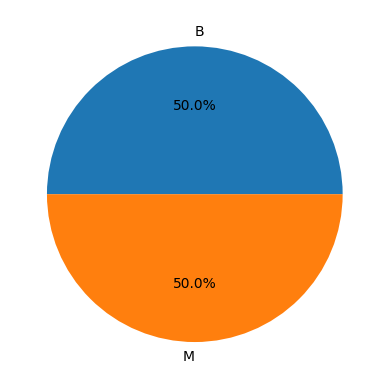

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resample , y_resample = smote.fit_resample(X,y)
print(X_resample.shape , y_resample.shape)
plt.pie(y_resample.value_counts() , labels=['B','M'] , autopct='%1.1f%%')

In [30]:
y_resample = y_resample.replace({'B':0 , 'M':1})

In [32]:
y_resample.value_counts()

diagnosis
1    357
0    357
Name: count, dtype: int64

In [36]:
X_train , X_test , y_train , y_test = train_test_split(X_resample , y_resample , test_size=0.3 , random_state=42,stratify=y_resample)
y_test.head()

129    1
267    0
594    1
670    1
321    1
Name: diagnosis, dtype: int64

### Modelling

In [41]:
from collections import defaultdict

res = defaultdict(dict)
models = ['LogisticRegression','GradientBoostingClassifier','AdaBoostClassifier','XGBClassifier']
for i in models:
    res[i] = {}

In [71]:
res

defaultdict(dict,
            {'LogisticRegression': {},
             'GradientBoostingClassifier': {},
             'AdaBoostClassifier': {},
             'XGBClassifier': {}})

Logistic Regression

with Smote

In [52]:
lr = LogisticRegression()
pipe_lr = Pipeline([('scaler',StandardScaler())
                    ,('pca',PCA(n_components=2))
                    ,('lr',lr)])
c_range = [0.001,0.01,0.1,1,10]
params_lr = [{'pca__n_components':[2,3,4],'lr__C':c_range,'lr__penalty':['l1','l2'],'lr__solver':['liblinear']},
             {'pca__n_components':[2,3,4],'lr__C':c_range,'lr__penalty':['l2',None],'lr__solver':['lbfgs']}]
random_lr = RandomizedSearchCV(estimator=pipe_lr,param_distributions=params_lr
                               ,cv=5,n_iter=10,scoring='accuracy',random_state=42,n_jobs=-1)

random_lr.fit(X_train,y_train)

print('Best Score: %.3f' % random_lr.best_score_)
print('\n Best parameters: %s' % random_lr.best_params_)
print('\n Best estimator: %s' % random_lr.best_estimator_)


Best Score: 0.910

 Best parameters: {'pca__n_components': 2, 'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 0.01}

 Best estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('lr', LogisticRegression(C=0.01))])


In [53]:
model_lr = random_lr.best_estimator_
y_pred = model_lr.predict(X_test)
accuracy  = accuracy_score(y_test,y_pred)
precision , recall = precision_score(y_test,y_pred,average='weighted') , recall_score(y_test,y_pred,average='weighted')
print('Test Accuracy: %.3f' % accuracy)
print(f'Precision: {precision:.3f} , Recall: {recall:.3f}')
print(f'Means Squared Error: {mean_squared_error(y_test,y_pred):.3f} , R2 Score: {r2_score(y_test,y_pred):.3f}')
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

Test Accuracy: 0.921
Precision: 0.925 , Recall: 0.921
Means Squared Error: 0.079 , R2 Score: 0.684
[[105   3]
 [ 14  93]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       108
           1       0.97      0.87      0.92       107

    accuracy                           0.92       215
   macro avg       0.93      0.92      0.92       215
weighted avg       0.93      0.92      0.92       215



Gradient Boost Classifier

In [65]:
gbs = GradientBoostingClassifier()
pipe_lr = Pipeline([('scaler',StandardScaler())
                    ,('pca',PCA(n_components=2))
                    ,('gbs',gbs)])
learning_rate = [0.001,0.01,0.1,1]
min_samples_split = [2,4,6,8]
min_samples_leaf = np.arange(0,11,2)
max_depth = np.arange(3,10,2)
params_gbs = {
    'learning_rate':learning_rate,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'max_depth':max_depth,
}
# params_gb = {'learning_rate': uniform(0.01, 0.1),
#                  'n_estimators': randint(100, 1000),
#                  'max_depth': randint(1, 10),
#                  'min_samples_split': randint(2, 10)}
random_gb = RandomizedSearchCV(estimator=gbs,param_distributions=params_gbs
                               ,cv=5,n_iter=10,scoring='accuracy',random_state=42,n_jobs=-1)

random_gb.fit(X_train,y_train)

print('Best Score: %.3f' % random_gb.best_score_)
print('\n Best parameters: %s' % random_gb.best_params_)
print('\n Best estimator: %s' % random_gb.best_estimator_)

Best Score: 0.946

 Best parameters: {'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 3, 'learning_rate': 0.01}

 Best estimator: GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=8,
                           min_samples_split=6)


In [66]:
model_gb = random_gb.best_estimator_
y_pred = model_gb.predict(X_test)
accuracy  = accuracy_score(y_test,y_pred)
precision , recall = precision_score(y_test,y_pred,average='weighted') , recall_score(y_test,y_pred,average='weighted')
print('Test Accuracy: %.3f' % accuracy)
print(f'Precision: {precision:.3f} , Recall: {recall:.3f}')
print(f'Means Squared Error: {mean_squared_error(y_test,y_pred):.3f} , R2 Score: {r2_score(y_test,y_pred):.3f}')
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))

Test Accuracy: 0.930
Precision: 0.931 , Recall: 0.930
Means Squared Error: 0.070 , R2 Score: 0.721
[[ 99   9]
 [  6 101]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       108
           1       0.92      0.94      0.93       107

    accuracy                           0.93       215
   macro avg       0.93      0.93      0.93       215
weighted avg       0.93      0.93      0.93       215



In [68]:
for i , x in enumerate(model_gb.feature_importances_):
    print(f'{X.columns[i]} : {x:.3f}')

concave points_mean : 0.862
perimeter_mean : 0.003
radius_mean : 0.004
area_mean : 0.100
concavity_mean : 0.031


In [ ]:
res['GradientBoostingClassifier']['Train'] = random_gb.best_score_
res['GradientBoostingClassifier']['best_params'] = random_gb.best_params_
res['GradientBoostingClassifier']['']